In [4]:
import torch
from torch.nn import MSELoss
from torch.optim import Adam
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SchNet, GCNConv, global_mean_pool
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#https://www.instagram.com/p/CE1hpU3HV_1/

In [55]:
class BasePreprocessor:
    def __init__(self, dataset, target=0):
        self.dataset = dataset
        self.target = target
        self._prepare_target()
    
    def _prepare_target(self):
        #for data in self.dataset:
        #    data.y = data.y[:, self.target].unsqueeze(0)
        self.dataset.data.y = self.dataset.data.y[:, self.target].unsqueeze(1)
    
    def get_dataset(self):
        raise NotImplementedError

        
    
class MLPPreprocessor(BasePreprocessor):
    # z and target
    def get_dataset(self):
        return [type(d)(z=d.z, y=d.y) for d in self.dataset]

class GCNPreprocessor(BasePreprocessor):
    # z,edge_index and target
    def get_dataset(self):
        return [type(d)(z=d.z, edge_index=d.edge_index, y=d.y) for d in self.dataset]

class SchNetPreprocessor(BasePreprocessor):
    def get_dataset(self):
        return self.dataset  # all fields


In [46]:
dataset = QM9(root='data/QM9')[:1000]

#pre_gcn = GCNPreprocessor(dataset)
#train_loader_gcn = DataLoader(pre_gcn.get_dataset()[:800], batch_size=32, shuffle=True)


In [56]:
pre = MLPPreprocessor(dataset)
train_loader = DataLoader(pre.get_dataset()[:800], batch_size=32, shuffle=True)

tensor([[0.0000],
        [1.6256],
        [1.8511],
        ...,
        [1.2480],
        [1.9576],
        [0.8626]])


In [65]:
for t in train_loader:
    print(t[0].y, t[0].z)
    print(t[0].y.shape, t[0].z.shape)
    break

tensor([[1.8900]]) tensor([6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([1, 1]) torch.Size([14])


In [ ]:
"""
t[0].y is the target for that graph

t[0].z is the list of atomic numbers of all nodes in that graph

"""

### most complete example

In [102]:
import torch
from torch.utils.data import random_split

from torch import nn
from torch_geometric.transforms import RadiusGraph


class BasePreprocessor:
    def __init__(self, dataset_cls=QM9, root='data/QM9', transform=None, 
                 target=0, val_ratio=0.2, seed=42, subset=1000):
        self.root = root
        self.subset = subset

        
        self.dataset_cls = dataset_cls
        self.transform = transform
        
        self.target = target
        self.val_ratio = val_ratio
        self.seed = seed

        self.dataset = self._load_dataset()
        self._prepare_target()
        
        
    def _load_dataset(self):
        dataset = self.dataset_cls(root=self.root, transform=self.transform)
        if self.subset:
            dataset = dataset[:self.subset]
        return dataset

    def _prepare_target(self):
        self.dataset.data.y = self.dataset.data.y[:, self.target].unsqueeze(1)

    def get_dataset(self):
        raise NotImplementedError

    def split(self):
        processed = self.get_dataset()

        n_val = int(len(processed) * self.val_ratio)
        n_train = len(processed) - n_val

        gen = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(processed, [n_train, n_val], generator=gen)
        return train_ds, val_ds
    
    
    # to test!!!
    def preprocess_single(self, data):
        """
        Preprocess one Data object without requiring 'y'.
        Useful for inference.
        """
        # Apply transform (e.g., RadiusGraph) if exists
        if self.transform is not None:
            data = self.transform(data)

        # Extract only fields needed by the model
        processed = self.get_dataset_item(data)

        return processed



    
    
class MLPPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        super().__init__(transform=None, **kwargs)

    def get_dataset(self):
        return [type(d)(z=d.z, y=d.y) for d in self.dataset]
    
    
    def get_dataset_item(self, d):
        return type(d)(z=d.z)   # no y during inference





class GCNPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        transform = RadiusGraph(r=1.5)
        super().__init__(transform=transform, **kwargs)

    def get_dataset(self):
        return [type(d)(z=d.z, edge_index=d.edge_index, y=d.y) for d in self.dataset]
    
    def get_dataset_item(self, d):
        return type(d)(z=d.z, edge_index=d.edge_index)



class SchNetPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        super().__init__(transform=None, **kwargs)

    def get_dataset(self):
        return self.dataset  # use full QM9 fields

    def get_dataset_item(self, d):
        return d   # SchNet expects full QM9-like input
    

    
    
"""
from torch_geometric.data import Data

# your input molecule without y
mol = Data(z=torch.tensor([6,6,1,1]), pos=...)

prep = GCNPreprocessor()        # same preprocessor you used during training
proc_mol = prep.preprocess_single(mol)
proc_mol = proc_mol.to(device)

model.eval()
with torch.no_grad():
    pred = model(proc_mol)

"""    


In [103]:
pp = MLPPreprocessor()

train_ds, val_ds = pp.split()



In [104]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [105]:
for t in train_loader:
    print(t[0].y, t[0].z)
    print(t[0].y.shape, t[0].z.shape)
    break

tensor([[1.3206]]) tensor([6, 6, 6, 8, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([1, 1]) torch.Size([16])


In [106]:
val_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

### first model

In [160]:
def run_epoch(loader, model, criterion, optimizer=None):
    model.train() if optimizer else model.eval()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.squeeze(-1)
        target = batch.y.squeeze(-1)
        loss = criterion(pred, target)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

In [161]:
#baseline
class SimpleMLP(nn.Module):
    def __init__(self, num_atom_types=100, hidden=64):
        super().__init__()
        self.emb = nn.Embedding(num_atom_types, hidden)
        self.fc = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, batch):
        x = self.emb(batch.z)       # [num_nodes, hidden]
        x = global_mean_pool(x, batch.batch)  # [num_graphs, hidden]
        #out = self.fc(x)            # [num_graphs, 1]
        out = self.fc(x).squeeze(-1)   # <-- from [N,1] → [N]
        return out

model_mlp = SimpleMLP().to(device)
optimizer = Adam(model_mlp.parameters(), lr=1e-3)
criterion = MSELoss()

# Train for a few epochs
for epoch in range(3):
    train_loss = run_epoch(train_loader, model_mlp, criterion, optimizer)
    val_loss = run_epoch(val_loader, model_mlp, criterion)
    print(f"[MLP] Epoch {epoch} | Train {train_loss:.4f} | Val {val_loss:.4f}")


[MLP] Epoch 0 | Train 4.1542 | Val 1.9468
[MLP] Epoch 1 | Train 2.3111 | Val 1.8398
[MLP] Epoch 2 | Train 2.2396 | Val 1.8080


### secodn model (GCN)

In [109]:
prep = GCNPreprocessor(root="data/QM9", subset=1000) 
train_ds, val_ds = prep.split()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


In [113]:
for t in train_loader:
    print(t[0].y, t[0].z, t[0].edge_index)
    print(t[0].y.shape, t[0].z.shape)
    break

tensor([[1.6815]]) tensor([6, 6, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1]) tensor([[ 7,  6,  8,  9, 11, 10, 12,  0,  0,  1,  2,  3,  3,  5],
        [ 0,  0,  1,  2,  3,  3,  5,  6,  7,  8,  9, 10, 11, 12]])
torch.Size([1, 1]) torch.Size([13])


In [157]:
# --- 2️⃣ Define Graph CNN ---
class SimpleGCN(nn.Module):
    def __init__(self, hidden=64, num_atom_types=100):
        super().__init__()
        self.emb = nn.Embedding(num_atom_types, hidden)
        self.conv1 = GCNConv(hidden, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, batch):
        x = self.emb(batch.z)           # [num_nodes, hidden]
        x = self.conv1(x, batch.edge_index) # using edge_index here!!!!!!!!!!!!!!!!!!!!
        x = torch.relu(x)
        x = self.conv2(x, batch.edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch.batch)  # [num_graphs, hidden]
        out = self.fc(x)                        # [num_graphs, 1]
        return out

model_gcn = SimpleGCN().to(device)
optimizer = Adam(model_gcn.parameters(), lr=1e-3)
criterion = MSELoss()

# --- 3️⃣ Training / evaluation loop ---
def run_epoch(loader, model, criterion, optimizer=None):
    model.train() if optimizer else model.eval()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.squeeze(-1)
        target = batch.y.squeeze(-1)
        loss = criterion(pred, target)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

# --- 4️⃣ Training ---
for epoch in range(1, 11):
    train_loss = run_epoch(train_loader, model_gcn, criterion, optimizer)
    val_loss = run_epoch(val_loader, model_gcn, criterion)
    print(f"Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

# --- 5️⃣ Test evaluation ---
test_loss = run_epoch(test_loader, model_gcn, criterion)
print(f"\nTest MSE: {test_loss:.4f}")


Epoch 01 | Train: 5.0653 | Val: 2.0500
Epoch 02 | Train: 2.2752 | Val: 1.6202
Epoch 03 | Train: 2.0057 | Val: 1.3771
Epoch 04 | Train: 1.9146 | Val: 1.3406
Epoch 05 | Train: 1.8673 | Val: 1.2940
Epoch 06 | Train: 1.8366 | Val: 1.2817
Epoch 07 | Train: 1.8179 | Val: 1.2711
Epoch 08 | Train: 1.8075 | Val: 1.2482
Epoch 09 | Train: 1.7765 | Val: 1.2281
Epoch 10 | Train: 1.7629 | Val: 1.2264

Test MSE: 1.7813


### third model

In [115]:
from torch_geometric.nn import SchNet

In [116]:
prep = SchNetPreprocessor(root="data/QM9", subset=1000) 
train_ds, val_ds = prep.split()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


In [155]:
# --- 2️⃣ Define SchNet model ---
model = SchNet(
    hidden_channels=64,
    num_filters=64,
    num_interactions=3,
    num_gaussians=50,
    cutoff=10.0,
    readout='add'  # important: aggregates node embeddings to graph embeddings
)
regressor = torch.nn.Linear(64, 1)

optimizer = Adam(list(model.parameters()) + list(regressor.parameters()), lr=1e-3)
criterion = MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, regressor = model.to(device), regressor.to(device)

# --- 3️⃣ Training / evaluation function ---
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        if train:
            optimizer.zero_grad()
        out = model(batch.z, batch.pos, batch.batch)  # [num_graphs, hidden_channels]


        #print(out.shape)
        
        #pred = regressor(out).squeeze(-1)             # [num_graphs]
        pred = out.squeeze(-1)

        #print(pred.shape)
        
        target = batch.y.squeeze(-1)                  # [num_graphs]


        #print(target.shape)
        
        loss = criterion(pred, target)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

# --- 4️⃣ Training loop ---
for epoch in range(1, 11):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

# --- 5️⃣ Test evaluation ---
test_loss = run_epoch(test_loader, train=False)
print(f"\nTest MSE: {test_loss:.4f}")


Epoch 01 | Train: 18.5604 | Val: 2.4889
Epoch 02 | Train: 2.9883 | Val: 2.1255
Epoch 03 | Train: 1.7688 | Val: 1.3324
Epoch 04 | Train: 1.4989 | Val: 1.1685
Epoch 05 | Train: 1.3955 | Val: 1.2185
Epoch 06 | Train: 1.3830 | Val: 1.0140
Epoch 07 | Train: 1.3312 | Val: 0.9522
Epoch 08 | Train: 1.3073 | Val: 0.9245
Epoch 09 | Train: 1.2092 | Val: 0.8561
Epoch 10 | Train: 1.1997 | Val: 0.9639

Test MSE: 1.1433


## <font color='blue'> NEW </font>

In [118]:
import torch
from torch.utils.data import random_split

from torch import nn
from torch_geometric.transforms import RadiusGraph


class BasePreprocessor:
    def __init__(self, dataset_cls=QM9, root='data/QM9', transform=None, 
                 target=0, val_ratio=0.2, seed=42, subset=1000):
        self.root = root
        self.subset = subset

        
        self.dataset_cls = dataset_cls
        self.transform = transform
        
        self.target = target
        self.val_ratio = val_ratio
        self.seed = seed

        
    def _load_dataset(self):
        dataset = self.dataset_cls(root=self.root, transform=self.transform)
        if self.subset:
            dataset = dataset[:self.subset]
        return dataset

    def _prepare_target(self):
        self.dataset.data.y = self.dataset.data.y[:, self.target].unsqueeze(1)

    def get_dataset(self):
        raise NotImplementedError

    def split(self, processed):
        n_val = int(len(processed) * self.val_ratio)
        n_train = len(processed) - n_val

        gen = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(processed, [n_train, n_val], generator=gen)
        return train_ds, val_ds
    
    
    
    # returns tran and val dataset (right now is common, if not implement in suibclasses)
    def preprocess(self):
        raise NotImplementedError
    
    
    def preprocess_test(self):
        raise NotImplementedError
        
    def preprocess_inference(self):
        raise NotImplementedError
    
    
    
    

class MLPPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        super().__init__(transform=None, **kwargs)

    def get_dataset(self):
        return [type(d)(z=d.z, y=d.y) for d in self.dataset]
    
    # no target
    def get_dataset_inference(self):
        return [type(d)(z=d.z) for d in self.dataset]
    
    # returns train and val ds
    def preprocess(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.split(self.get_dataset())
    
    # retunrs test dataset
    def preprocess_test(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.get_dataset()
    
    # inference (no target)
    def preprocess_inference(self):
        self.dataset = self._load_dataset()
        return self.get_dataset_inference()
    
    

    
    
    
class GCNPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        # if is not given
        if not self.transform:
            transform = RadiusGraph(r=1.5)
        super().__init__(transform=transform, **kwargs)

    def get_dataset(self):
        return [type(d)(z=d.z, edge_index=d.edge_index, y=d.y) for d in self.dataset]
    
    # no target
    def get_dataset_inference(self):
        return [type(d)(z=d.z, edge_index=d.edge_index) for d in self.dataset]
    
    # returns train and val ds
    def preprocess(self):
        self.dataset = self._load_dataset() # in here is where i apply the transform
        self._prepare_target()
        return self.split(self.get_dataset())
    
    # retunrs test dataset (no split)
    def preprocess_test(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.get_dataset()
    
    # inference (no target)
    def preprocess_inference(self):
        self.dataset = self._load_dataset()
        return self.get_dataset_inference()
    



class SchNetPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        super().__init__(transform=None, **kwargs)

    def get_dataset(self):
        return self.dataset  # use full QM9 fields
    
    
    
    # no target
    def get_dataset_inference(self):
        return [type(d)(z=d.z, edge_index=d.edge_index) for d in self.dataset]
    
    # returns train and val ds
    def preprocess(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.split(self.get_dataset())
    
    # retunrs test dataset (no split)
    def preprocess_test(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.get_dataset()
    
    # inference (no target)
    def preprocess_inference(self):
        self.dataset = self._load_dataset()
        return self.get_dataset_inference()

    

    


In [119]:
#prep = GCNPreprocessor(root="data/QM9", subset=1000) 

prep = MLPPreprocessor(root="data/QM9", subset=1000)
train_ds, val_ds = prep.preprocess()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


In [123]:
for t in train_loader:
    print(t[1].y, t[1].z, t[1].edge_index)
    print(t[1].y.shape, t[1].z.shape)
    break

tensor([[0.0024]]) tensor([7, 6, 8, 6, 7, 8, 1, 1, 1, 1]) None
torch.Size([1, 1]) torch.Size([10])


## <font color='red'> vamos!! </font>

In [131]:
import torch
from torch.utils.data import random_split
from torch_geometric.transforms import RadiusGraph


class BasePreprocessor:
    def __init__(self, dataset_cls=QM9, root='data/QM9',
                 transform=None, target=0, val_ratio=0.2,
                 seed=42, subset=None):

        self.dataset_cls = dataset_cls
        self.root = root
        self.transform = transform
        self.target = target
        self.val_ratio = val_ratio
        self.seed = seed
        self.subset = subset

    # -------------------------
    # Loading dataset
    # -------------------------
    def _load_dataset(self):
        dataset = self.dataset_cls(root=self.root, transform=self.transform)

        if self.subset:
            dataset = dataset[:self.subset]

        return dataset

    # -------------------------
    # Slice target column
    # -------------------------
    def _prepare_target(self):
        self.dataset.data.y = self.dataset.data.y[:, self.target].unsqueeze(1)


    # -------------------------
    # Split train/val
    # -------------------------
    def split(self, processed):
        n_val = int(len(processed) * self.val_ratio)
        n_train = len(processed) - n_val

        gen = torch.Generator().manual_seed(self.seed)
        return random_split(processed, [n_train, n_val], generator=gen)

    # -------------------------
    # Abstract
    # -------------------------
    def preprocess(self): raise NotImplementedError
    def preprocess_test(self): raise NotImplementedError
    def preprocess_inference(self): raise NotImplementedError



# ---------------------------------------------------------
# MLP
# ---------------------------------------------------------

class MLPPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        super().__init__(transform=None, **kwargs)

    def get_dataset(self):
        return [type(d)(z=d.z, y=d.y) for d in self.dataset]

    def get_dataset_inference(self):
        return [type(d)(z=d.z) for d in self.dataset]

    # Train/val
    def preprocess(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.split(self.get_dataset())

    # Test
    def preprocess_test(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.get_dataset()

    # Inference
    def preprocess_inference(self):
        self.dataset = self._load_dataset()
        return self.get_dataset_inference()



# ---------------------------------------------------------
# GCN
# ---------------------------------------------------------

class GCNPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        # Replace transform ONLY if the user didn't supply one
        transform = kwargs.get("transform", RadiusGraph(r=1.5))
        super().__init__(transform=transform, **kwargs)

    def get_dataset(self):
        return [type(d)(z=d.z, edge_index=d.edge_index, y=d.y)
                for d in self.dataset]

    def get_dataset_inference(self):
        return [type(d)(z=d.z, edge_index=d.edge_index)
                for d in self.dataset]

    def preprocess(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.split(self.get_dataset())

    def preprocess_test(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.get_dataset()

    def preprocess_inference(self):
        self.dataset = self._load_dataset()
        return self.get_dataset_inference()



# ---------------------------------------------------------
# SchNet
# ---------------------------------------------------------

class SchNetPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        super().__init__(transform=None, **kwargs)

    def get_dataset(self):
        return self.dataset

    def get_dataset_inference(self):
        return [type(d)(z=d.z, pos=d.pos) for d in self.dataset]

    def preprocess(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.split(self.get_dataset())

    def preprocess_test(self):
        self.dataset = self._load_dataset()
        self._prepare_target()
        return self.get_dataset()

    def preprocess_inference(self):
        self.dataset = self._load_dataset()
        return self.get_dataset_inference()


In [158]:
prep = MLPPreprocessor(root="data/QM9", subset=1000)
train_ds, val_ds = prep.preprocess()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


for t in train_loader:
    print(t[1].y, t[1].z, t[1].edge_index)
    print(t[1].y.shape, t[1].z.shape)
    break

tensor([[2.0793]]) tensor([6, 6, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]) None
torch.Size([1, 1]) torch.Size([14])


In [133]:
for t in train_loader:
    print(t[1].y, t[1].z, t[1].edge_index)
    print(t[1].y.shape, t[1].z.shape)
    break

tensor([[3.1035]]) tensor([8, 6, 7, 7, 6, 1, 1]) None
torch.Size([1, 1]) torch.Size([7])


In [ ]:
# for later logging



def collect_metadata(
    target_index: int,
    transform: str,
    train_dataset,
    val_dataset,
    test_dataset=None,
    seed: int = 42,
    extra: dict = None
):
    """
    Collects dataset + preprocessing metadata for MLflow logging.

    Parameters
    ----------
    target_index : int
        Which target (column) you selected.
    transform : str
        Name of the transform/preprocessing applied.
        (e.g. "AtomTypeEncoding", "NormalizeTarget(mean,std)", etc.)
    train_dataset : Dataset
    val_dataset : Dataset
    test_dataset : Dataset or None
    seed : int
        Random seed used for splitting.
    extra : dict
        Any extra info you want to log (optional).

    Returns
    -------
    dict
        Metadata ready to be logged into MLflow.
    """

    meta = {
        "target_index": target_index,
        "transform": transform,
        "seed": seed,
        "num_train": len(train_dataset),
        "num_val": len(val_dataset),
        "num_test": len(test_dataset) if test_dataset else 0,
        "train_class": type(train_dataset).__name__,
    }

    if extra:
        meta.update(extra)

    return meta


# el que voy a usar!

In [150]:
import torch
from torch.utils.data import random_split
# Assuming QM9 is available in your environment, e.g., from torch_geometric.datasets
# from torch_geometric.datasets import QM9 
# For demonstration, we'll assume QM9 is imported or defined elsewhere.

# --- External Dependencies (For illustrative purposes, assuming they are available) ---
# NOTE: You must ensure QM9 is imported or defined in your actual environment.
try:
    from torch_geometric.datasets import QM9
except ImportError:
    # Fallback/Dummy definition if not using torch_geometric context for running
    class QM9:
        def __init__(self, *args, **kwargs):
            print("Warning: QM9 dataset is a placeholder. Ensure torch_geometric is installed.")
            # Dummy attributes for the code to pass checks
            self.data = type('DummyData', (object,), {'y': torch.randn(100, 12), 'z': torch.randint(1, 10, (100,)), 'pos': torch.randn(100, 3)})
            self.len = lambda: 100
            self.processed_paths = [] # Needed for torch_geometric dataset initialization
        def __getitem__(self, idx):
            return self.data
        def __len__(self):
            return self.len()
# -----------------------------------------------------------------------------------

from torch_geometric.transforms import RadiusGraph


class BasePreprocessor:
    """
    Base class for data preprocessing, handling common tasks like loading, 
    subsetting, splitting, and configuration.
    """
    def __init__(self, dataset_cls=QM9, root='data/QM9',
                 transform=None, target=0, val_ratio=0.2,
                 seed=42, subset=None):

        self.dataset_cls = dataset_cls
        self.root = root
        self.transform = transform
        self.target = target
        self.val_ratio = val_ratio
        self.seed = seed
        self.subset = subset
        # Initialize internal storage for the dataset
        self._dataset = None

    # -------------------------
    # Loading dataset (Lazy-loaded)
    # -------------------------
    def _load_dataset(self):
        """Loads the dataset once and caches it."""
        if self._dataset is None:
            # Load the dataset (expensive I/O operation)
            dataset = self.dataset_cls(root=self.root, transform=self.transform)

            if self.subset:
                # Apply subset slicing
                dataset = dataset[:self.subset]
            
            self._dataset = dataset
            
        return self._dataset

    # -------------------------
    # Split train/val
    # -------------------------
    def split(self, processed):
        """Splits the processed dataset into train and validation sets."""
        n_val = int(len(processed) * self.val_ratio)
        # Ensure n_train is the remainder to cover the whole dataset
        n_train = len(processed) - n_val 

        gen = torch.Generator().manual_seed(self.seed)
        return random_split(processed, [n_train, n_val], generator=gen)

    # -------------------------
    # Abstract/Helper
    # -------------------------
    def _get_dataset(self, dataset, is_inference):
        """
        Abstract method for model-specific data formatting and target slicing.
        Must be implemented by subclasses.
        """
        raise NotImplementedError

    # -------------------------
    # Concrete Workflow Methods (Handle Redundancy)
    # -------------------------
    
    def preprocess(self):
        """Workflow for train/validation: Load -> Format -> Split."""
        dataset = self._load_dataset()
        processed = self._get_dataset(dataset, is_inference=False)
        return self.split(processed)

    def preprocess_test(self):
        """Workflow for test: Load -> Format -> Return."""
        dataset = self._load_dataset()
        return self._get_dataset(dataset, is_inference=False)

    def preprocess_inference(self):
        """Workflow for inference: Load -> Format (no target) -> Return."""
        dataset = self._load_dataset()
        return self._get_dataset(dataset, is_inference=True)


# ---------------------------------------------------------
# MLP Preprocessor
# ---------------------------------------------------------

class MLPPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        # MLP doesn't need graph transforms
        super().__init__(transform=None, **kwargs)

    def _get_dataset(self, dataset, is_inference):
        """Extracts atomic numbers (z) and (optionally) the target (y)."""
        
        # We assume the base dataset returns Data objects, and we create new ones
        # with only the necessary features (z for MLP input).
        
        if is_inference:
            return [type(d)(z=d.z) for d in dataset]
        else:
            # Safely slice the target column and unsqueeze for correct shape
            target_col = self.target
            return [type(d)(z=d.z, y=d.y[:, target_col].unsqueeze(1)) for d in dataset]


# ---------------------------------------------------------
# GCN Preprocessor
# ---------------------------------------------------------

class GCNPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        # Get user-supplied transform or use the default RadiusGraph
        transform = kwargs.pop("transform", RadiusGraph(r=1.5))
        super().__init__(transform=transform, **kwargs)

    """
    def _get_dataset(self, dataset, is_inference):
        Extracts atomic numbers (z), edge_index, and (optionally) the target (y).

        if is_inference:
            return [type(d)(z=d.z, edge_index=d.edge_index) for d in dataset]
        else:
            target_col = self.target
            # Requires z, edge_index, and the sliced target
            return [type(d)(z=d.z, edge_index=d.edge_index, 
                            y=d.y[:, target_col].unsqueeze(1))
                    for d in dataset]
    """
    def _get_dataset(self, dataset, is_inference):
        target_col = self.target
        if is_inference:
            return [
                type(d)(z=d.z, pos=d.pos, edge_index=d.edge_index)
                for d in dataset
            ]
        else:
            return [
                type(d)(
                    z=d.z,
                    pos=d.pos,
                    edge_index=d.edge_index,
                    y=d.y[:, target_col].unsqueeze(1)
                )
                for d in dataset
            ]


# ---------------------------------------------------------
# SchNet Preprocessor
# ---------------------------------------------------------

class SchNetPreprocessor(BasePreprocessor):
    def __init__(self, **kwargs):
        # SchNet often handles connectivity internally (e.g., using radius graph
        # and pos), so we might not need an explicit transform here, depending on 
        # how the model is implemented. Sticking with None for consistency.
        super().__init__(transform=None, **kwargs)
        
        
        
    """
    def _get_dataset(self, dataset, is_inference):

        if is_inference:
            return [type(d)(z=d.z, pos=d.pos) for d in dataset]
        else:
            target_col = self.target
            # Requires z, pos, and the sliced target
            return [type(d)(z=d.z, pos=d.pos, 
                            y=d.y[:, target_col].unsqueeze(1))
                    for d in dataset]
    """
    def _get_dataset(self, dataset, is_inference):
        target_col = self.target

        processed = []
        for d in dataset:
            d_new = d.clone()  # <-- keeps all fields: pos, z, edge_index, etc

            if is_inference:
                # remove y safely if exists
                if hasattr(d_new, "y"):
                    del d_new.y
            else:
                d_new.y = d.y[:, target_col].unsqueeze(1)

            processed.append(d_new)

        return processed

In [151]:
prep = MLPPreprocessor(root="data/QM9", subset=1000)
train_ds, val_ds = prep.preprocess()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


for t in train_loader:
    print(t[1].y, t[1].z, t[1].edge_index)
    print(t[1].y.shape, t[1].z.shape)
    break

tensor([[0.9638]]) tensor([8, 7, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1]) None
torch.Size([1, 1]) torch.Size([14])


In [154]:
prep = SchNetPreprocessor(root="data/QM9", subset=1000)
train_ds, val_ds = prep.preprocess()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


for t in train_loader:
    print(t[1].y, t[1].z, t[1].edge_index)
    print(t[1].y.shape, t[1].z.shape)
    break

tensor([[2.5958]]) tensor([8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]) tensor([[ 0,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,
          6,  7,  8,  9, 10, 11],
        [ 1,  0,  2,  5,  1,  3,  6,  7,  2,  4,  8,  3,  5,  9,  1,  4, 10, 11,
          2,  2,  3,  4,  5,  5]])
torch.Size([1, 1]) torch.Size([12])


In [156]:
prep = GCNPreprocessor(root="data/QM9", subset=1000)
train_ds, val_ds = prep.preprocess()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


for t in train_loader:
    print(t[1].y, t[1].z, t[1].edge_index)
    print(t[1].y.shape, t[1].z.shape)
    break

tensor([[3.2791]]) tensor([8, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]) tensor([[ 6,  1,  7,  8,  0,  9, 10, 12, 11, 13,  5,  4,  0,  1,  1,  2,  2,  3,
          3,  4],
        [ 0,  0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  5,  6,  7,  8,  9, 10, 11,
         12, 13]])
torch.Size([1, 1]) torch.Size([14])


# 

In [62]:
dataset.data

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 1], pos=[2359210, 3], z=[2359210], smiles=[130831], name=[130831], idx=[130831])

In [54]:
dataset.data.y[:,0].unsqueeze(1)

tensor([[0.0000],
        [1.6256],
        [1.8511],
        ...,
        [1.2480],
        [1.9576],
        [0.8626]])

In [60]:
dataset.data

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 1], pos=[2359210, 3], z=[2359210], smiles=[130831], name=[130831], idx=[130831])

In [15]:
# Use a small QM9 subset
dataset = QM9(root='data/QM9')[:1000]
target = 0
dataset.data.y = dataset.data.y[:, target].unsqueeze(1)

train_dataset = dataset[:800]
val_dataset = dataset[800:900]
test_dataset = dataset[900:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


/home/marcos/.local/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [18]:
for t in train_loader:
    print(t[1])
    break

Data(x=[11, 11], edge_index=[2, 22], edge_attr=[22, 4], y=[1, 1], pos=[11, 3], z=[11], smiles='[H]C1=C(C([H])([H])[H])N([H])N=N1', name='gdb_728', idx=[1])


In [2]:
def run_epoch(loader, model, criterion, optimizer=None):
    model.train() if optimizer else model.eval()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.squeeze(-1)
        target = batch.y.squeeze(-1)
        loss = criterion(pred, target)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


In [3]:
#baseline
class SimpleMLP(nn.Module):
    def __init__(self, num_atom_types=100, hidden=64):
        super().__init__()
        self.emb = nn.Embedding(num_atom_types, hidden)
        self.fc = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, batch):
        x = self.emb(batch.z)       # [num_nodes, hidden]
        x = global_mean_pool(x, batch.batch)  # [num_graphs, hidden]
        out = self.fc(x)            # [num_graphs, 1]
        return out

model_mlp = SimpleMLP().to(device)
optimizer = Adam(model_mlp.parameters(), lr=1e-3)
criterion = MSELoss()

# Train for a few epochs
for epoch in range(5):
    train_loss = run_epoch(train_loader, model_mlp, criterion, optimizer)
    val_loss = run_epoch(val_loader, model_mlp, criterion)
    print(f"[MLP] Epoch {epoch} | Train {train_loss:.4f} | Val {val_loss:.4f}")


[MLP] Epoch 0 | Train 5.0509 | Val 3.5970
[MLP] Epoch 1 | Train 2.5253 | Val 2.6134
[MLP] Epoch 2 | Train 2.3496 | Val 2.6361
[MLP] Epoch 3 | Train 2.1943 | Val 2.4377
[MLP] Epoch 4 | Train 2.0478 | Val 2.2699


In [7]:
import torch
from torch.nn import MSELoss
from torch.optim import Adam
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch import nn
from torch_geometric.transforms import RadiusGraph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1️⃣ Load dataset with edge_index ---
# Connect atoms within 1.5 Å automatically
transform = RadiusGraph(r=1.5)
dataset = QM9(root='data/QM9', transform=transform)[:1000]  # trnasform becuase o how i need data

# Pick one target property (index 0 = mu)
target = 0
dataset.data.y = dataset.data.y[:, target].unsqueeze(1)

# Split dataset
train_dataset = dataset[:800]
val_dataset = dataset[800:900]
test_dataset = dataset[900:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# --- 2️⃣ Define Graph CNN ---
class SimpleGCN(nn.Module):
    def __init__(self, hidden=64, num_atom_types=100):
        super().__init__()
        self.emb = nn.Embedding(num_atom_types, hidden)
        self.conv1 = GCNConv(hidden, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, batch):
        x = self.emb(batch.z)           # [num_nodes, hidden]
        x = self.conv1(x, batch.edge_index) # using edge_index here!!!!!!!!!!!!!!!!!!!!
        x = torch.relu(x)
        x = self.conv2(x, batch.edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch.batch)  # [num_graphs, hidden]
        out = self.fc(x)                        # [num_graphs, 1]
        return out

model_gcn = SimpleGCN().to(device)
optimizer = Adam(model_gcn.parameters(), lr=1e-3)
criterion = MSELoss()

# --- 3️⃣ Training / evaluation loop ---
def run_epoch(loader, model, criterion, optimizer=None):
    model.train() if optimizer else model.eval()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.squeeze(-1)
        target = batch.y.squeeze(-1)
        loss = criterion(pred, target)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

# --- 4️⃣ Training ---
for epoch in range(1, 11):
    train_loss = run_epoch(train_loader, model_gcn, criterion, optimizer)
    val_loss = run_epoch(val_loader, model_gcn, criterion)
    print(f"Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

# --- 5️⃣ Test evaluation ---
test_loss = run_epoch(test_loader, model_gcn, criterion)
print(f"\nTest MSE: {test_loss:.4f}")


Epoch 01 | Train: 5.3607 | Val: 2.3487
Epoch 02 | Train: 2.2864 | Val: 2.3033
Epoch 03 | Train: 1.9929 | Val: 1.9392
Epoch 04 | Train: 1.8667 | Val: 1.8532
Epoch 05 | Train: 1.8119 | Val: 1.7958
Epoch 06 | Train: 1.7739 | Val: 1.7893
Epoch 07 | Train: 1.7454 | Val: 1.8165
Epoch 08 | Train: 1.7390 | Val: 1.7486
Epoch 09 | Train: 1.7154 | Val: 1.7914
Epoch 10 | Train: 1.7049 | Val: 1.7322

Test MSE: 1.8528


## schnet

In [6]:
import torch
from torch.nn import MSELoss
from torch.optim import Adam
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SchNet

# --- 1️⃣ Load dataset ---
dataset = QM9(root='data/QM9')

# Pick a single target property (index 0 = mu: dipole moment)
target = 0
dataset.data.y = dataset.data.y[:, target].unsqueeze(1)

# Use a small subset for testing
dataset = dataset[:1000]  # fast subset

# Split into train/val/test
train_dataset = dataset[:800]
val_dataset = dataset[800:900]
test_dataset = dataset[900:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# --- 2️⃣ Define SchNet model ---
model = SchNet(
    hidden_channels=64,
    num_filters=64,
    num_interactions=3,
    num_gaussians=50,
    cutoff=10.0,
    readout='add'  # important: aggregates node embeddings to graph embeddings
)
regressor = torch.nn.Linear(64, 1)

optimizer = Adam(list(model.parameters()) + list(regressor.parameters()), lr=1e-3)
criterion = MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, regressor = model.to(device), regressor.to(device)

# --- 3️⃣ Training / evaluation function ---
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        if train:
            optimizer.zero_grad()
        out = model(batch.z, batch.pos, batch.batch)  # [num_graphs, hidden_channels]


        #print(out.shape)
        
        #pred = regressor(out).squeeze(-1)             # [num_graphs]
        pred = out.squeeze(-1)

        #print(pred.shape)
        
        target = batch.y.squeeze(-1)                  # [num_graphs]


        #print(target.shape)
        
        loss = criterion(pred, target)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

# --- 4️⃣ Training loop ---
for epoch in range(1, 11):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

# --- 5️⃣ Test evaluation ---
test_loss = run_epoch(test_loader, train=False)
print(f"\nTest MSE: {test_loss:.4f}")


/home/marcos/.local/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 01 | Train: 9.9091 | Val: 4.0013
Epoch 02 | Train: 2.0343 | Val: 2.5900
Epoch 03 | Train: 1.6415 | Val: 2.3200
Epoch 04 | Train: 1.3812 | Val: 2.3489
Epoch 05 | Train: 1.2391 | Val: 1.8984
Epoch 06 | Train: 1.1916 | Val: 1.8889
Epoch 07 | Train: 1.2065 | Val: 1.7359
Epoch 08 | Train: 1.2426 | Val: 1.8925
Epoch 09 | Train: 1.0563 | Val: 1.5483
Epoch 10 | Train: 1.0155 | Val: 2.0863

Test MSE: 1.7309


## Inpsetc data

In [14]:
dataset = QM9(root='data/QM9')

dataset.data

/home/marcos/.local/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], z=[2359210], smiles=[130831], name=[130831], idx=[130831])

In [31]:
dataset.data

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], z=[2359210], smiles=[130831], name=[130831], idx=[130831])

In [32]:
dataset[3]

Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], z=[4], smiles='[H]C#C[H]', name='gdb_4', idx=[1])

In [35]:
data = dataset.data

print("Total atoms:", data.x.size(0))
print("Total edges:", data.edge_index.size(1))
print("Number of molecules:", data.y.size(0))
print("Node feature size:", data.x.size(1))
print("Edge feature size:", data.edge_attr.size(1))
print("Targets per molecule:", data.y.size(1))


Total atoms: 2359210
Total edges: 4883516
Number of molecules: 130831
Node feature size: 11
Edge feature size: 4
Targets per molecule: 19


In [38]:
dataset[3].x, dataset[3].edge_index, dataset[3].smiles

(tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 tensor([[0, 0, 1, 1, 2, 3],
         [1, 3, 0, 2, 1, 0]]),
 '[H]C#C[H]')

In [15]:
num_molecules = dataset.data.y.size(0)
print("Number of molecules:", num_molecules)


Number of molecules: 130831


In [16]:
# per-molecule stats
import torch

data = dataset.data

# Number of molecules
num_molecules = data.y.size(0)
print("Number of molecules:", num_molecules)

# Target (dipole moment)
mu = data.y[:, 0]  # we already selected target=0
print("Mean mu:", mu.mean().item())
print("Std mu:", mu.std().item())
print("Min mu:", mu.min().item())
print("Max mu:", mu.max().item())

# Number of atoms per molecule
# QM9 z contains atomic numbers stacked per atom; 
# so we can count how many atoms correspond to each molecule by dividing z equally if needed
# The simplest: number of atoms = data.pos.size(0) / num_molecules
avg_atoms = data.pos.size(0) / num_molecules
print("Average number of atoms per molecule:", avg_atoms)


Number of molecules: 130831
Mean mu: 2.6729531288146973
Std mu: 1.5034793615341187
Min mu: 0.0
Max mu: 29.556400299072266
Average number of atoms per molecule: 18.032499942674136


In [18]:
"""
For proper molecule-wise atom counts, you might need to rebuild batch indices. PyTorch Geometric 
provides torch_geometric.data.InMemoryDataset.get(idx) which returns a Data object per molecule:
"""

first_molecule = dataset[0]
print(first_molecule)
print("Atoms in first molecule:", first_molecule.num_nodes)
print("Edges in first molecule:", first_molecule.num_edges)
print("Dipole moment:", first_molecule.y)


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])
Atoms in first molecule: 5
Edges in first molecule: 8
Dipole moment: tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])


In [26]:
data[0].y[0]

tensor([    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
            1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
          -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
          157.7070])

Number of molecules: 130831
Dipole moment (mu) stats:
Mean: 2.672952890396118
Std: 1.5034793615341187
Min: 0.0
Max: 29.556400299072266


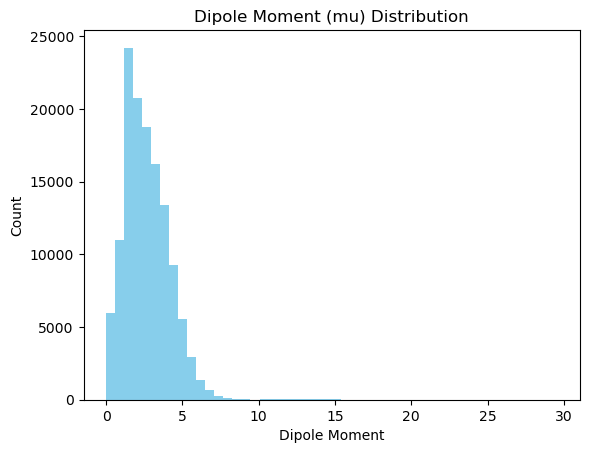

Number of atoms per molecule stats:
Mean: 18.032499313354492
Min: 3
Max: 29


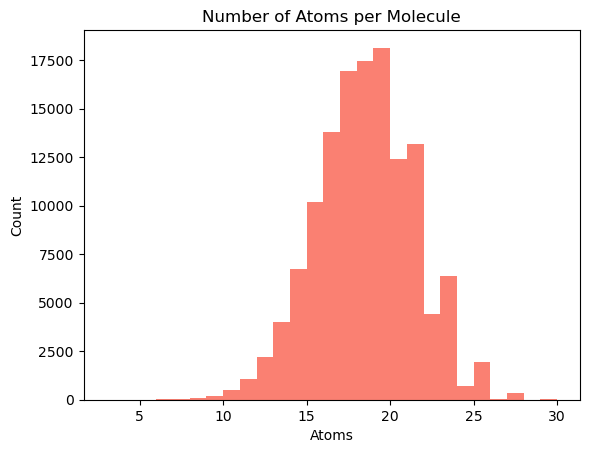

Bond type counts: Counter({0: 14})


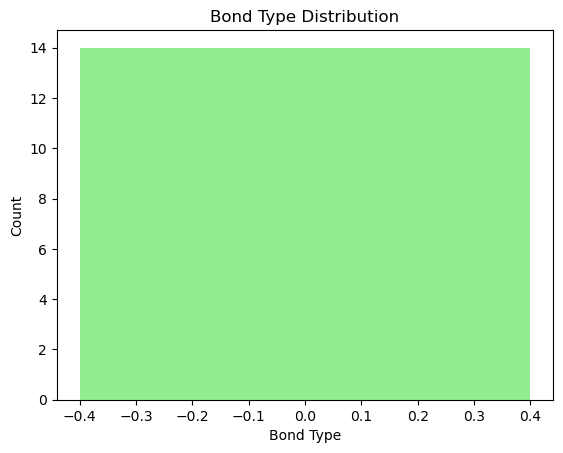

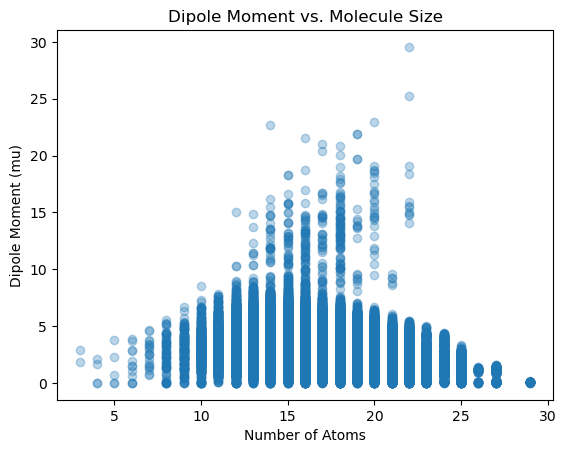

In [28]:
import torch
import matplotlib.pyplot as plt
from collections import Counter

data = dataset  # QM9 dataset
num_molecules = len(data)
print("Number of molecules:", num_molecules)

# ---- 1️⃣ Target (dipole moment) ----
target = 0  # dipole moment (mu)
mu_list = [data[i].y[0, target].item() for i in range(num_molecules)]
mu_tensor = torch.tensor(mu_list)

print("Dipole moment (mu) stats:")
print("Mean:", mu_tensor.mean().item())
print("Std:", mu_tensor.std().item())
print("Min:", mu_tensor.min().item())
print("Max:", mu_tensor.max().item())

plt.hist(mu_tensor.numpy(), bins=50, color='skyblue')
plt.title('Dipole Moment (mu) Distribution')
plt.xlabel('Dipole Moment')
plt.ylabel('Count')
plt.show()

# ---- 2️⃣ Number of atoms per molecule ----
num_atoms_list = [data[i].num_nodes for i in range(num_molecules)]
num_atoms_tensor = torch.tensor(num_atoms_list)

print("Number of atoms per molecule stats:")
print("Mean:", num_atoms_tensor.float().mean().item())
print("Min:", num_atoms_tensor.min().item())
print("Max:", num_atoms_tensor.max().item())

plt.hist(num_atoms_tensor.numpy(), bins=range(num_atoms_tensor.min(), num_atoms_tensor.max()+2), color='salmon')
plt.title('Number of Atoms per Molecule')
plt.xlabel('Atoms')
plt.ylabel('Count')
plt.show()

# ---- 3️⃣ Bond type distribution ----
bond_types = []
#for i in range(num_molecules):
for i in range(2):
    edge_attr = data[i].edge_attr
    if edge_attr is not None:
        bond_types.extend(edge_attr.argmax(dim=1).tolist())  # one-hot to bond type

bond_counter = Counter(bond_types)
print("Bond type counts:", bond_counter)

plt.bar(bond_counter.keys(), bond_counter.values(), color='lightgreen')
plt.title('Bond Type Distribution')
plt.xlabel('Bond Type')
plt.ylabel('Count')
plt.show()

# ---- 4️⃣ Optional: Dipole vs. Number of atoms ----
plt.scatter(num_atoms_tensor.numpy(), mu_tensor.numpy(), alpha=0.3)
plt.xlabel('Number of Atoms')
plt.ylabel('Dipole Moment (mu)')
plt.title('Dipole Moment vs. Molecule Size')
plt.show()


## data to each model

In [39]:
dataset = QM9(root='data/QM9')[:1000]
target = 0
dataset.data.y = dataset.data.y[:, target].unsqueeze(1)

train_dataset = dataset[:800]
val_dataset = dataset[800:900]
test_dataset = dataset[900:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


/home/marcos/.local/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [45]:
train_dataset[0], type(train_dataset[0])

(Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 1], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1]),
 torch_geometric.data.data.Data)

In [44]:
for batch in train_loader:
    print(batch[0])
    break

Data(x=[11, 11], edge_index=[2, 22], edge_attr=[22, 4], y=[1, 1], pos=[11, 3], z=[11], smiles='[H]C1=C([H])C(N([H])[H])=C([H])O1', name='gdb_207', idx=[1])


Data(
    x=[11, 11],           # 11 nodes (atoms), 11 features per atom
    edge_index=[2, 22],   # 22 edges
    edge_attr=[22, 4],    # 4 features per edge
    y=[1, 1],             # target per graph? looks like 1x1
    pos=[11, 3],          # 3D coordinates
    z=[11],               # atomic numbers
    smiles='...', name='...', idx=[1]
)
batch.z → shape [num_nodes] = [11], good for nn.Embedding.

global_mean_pool(x, batch.batch) → expects x [num_nodes, hidden] and batch.batch [num_nodes].

batch.y → shape [num_graphs, 1] expected by your loss function (MSE for QM9)

| Attribute     | Shape             | Meaning                                             | Used in SimpleMLP?                |
| ------------- | ----------------- | --------------------------------------------------- | --------------------------------- |
| `x`           | `[num_nodes, 11]` | Node features (could be one-hot, chemical features) | ❌ Not used here                   |
| `z`           | `[num_nodes]`     | Atomic numbers (H=1, C=6, N=7, O=8, F=9)            | ✅ Used as input to `nn.Embedding` |
| `pos`         | `[num_nodes, 3]`  | 3D coordinates of atoms                             | ❌ Not used                        |
| `edge_index`  | `[2, num_edges]`  | Graph connectivity (which atom is bonded to which)  | ❌ Not used                        |
| `edge_attr`   | `[num_edges, 4]`  | Bond type/features                                  | ❌ Not used                        |
| `y`           | `[1]`             | Target property (dipole moment)                     | ✅ Used as label                   |
| `batch.batch` | `[num_nodes]`     | Maps nodes to molecules in batch                    | ✅ Used for pooling                |


In [49]:
dataset[0].z # just what atoms exist

tensor([6, 1, 1, 1, 1])

In [47]:
dataset[17].z

tensor([6, 6, 6, 8, 1, 1, 1, 1, 1, 1])

In [50]:
"""
Length = 5 → this molecule has 5 atoms.

Values: 6, 1, 1, 1, 1 → atomic numbers (C=6, H=1, H=1, H=1, H=1).
"""

'\nLength = 5 → this molecule has 5 atoms.\n\nValues: 6, 1, 1, 1, 1 → atomic numbers (C=6, H=1, H=1, H=1, H=1).\n'

## second molde

In [51]:
# Connect atoms within 1.5 Å automatically
transform = RadiusGraph(r=1.5)
dataset = QM9(root='data/QM9', transform=transform)[:1000]  # trnasform becuase o how i need data

# Pick one target property (index 0 = mu)
target = 0
dataset.data.y = dataset.data.y[:, target].unsqueeze(1)


In [52]:
dataset[0]

Data(x=[5, 11], edge_index=[2, 8], y=[1, 1], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

In [53]:
dataset[0].z

tensor([6, 1, 1, 1, 1])

In [54]:
# uses schnet

Input Data:
z   = [6, 1, 1, 1, 1]       # atomic numbers
pos = [[0,0,0], [1,0,0], [0,1,0], [0,0,1], [1,1,1]]  # 3D coords
batch = [0, 0, 0, 0, 0]     # all atoms belong to same molecule

Step 1: Atom Embedding
C -> emb(6) -> x0
H -> emb(1) -> x1
H -> emb(1) -> x2
H -> emb(1) -> x3
H -> emb(1) -> x4

x = [x0, x1, x2, x3, x4]   # shape [5, hidden]

Step 2: Compute pairwise distances
r_ij = ||pos[i] - pos[j]||
Example: r_01 = distance(C-H) = sqrt(1^2 + 0^2 + 0^2) = 1

Step 3: Message passing
x0' = sum_j f_theta(r_0j) * xj  # C gathers info from nearby Hs
x1' = sum_j f_theta(r_1j) * xj  # each H gathers info from neighbors

Step 4: Repeat for num_interactions layers
# Now node embeddings encode local geometric environment

Step 5: Graph pooling (readout='add')
graph_vec = sum(x0', x1', x2', x3', x4')  # shape [1, hidden]

Step 6: MLP to predict target
out = fc(graph_vec)  # shape [1, 1]


SyntaxError: unterminated string literal (detected at line 22) (2043804617.py, line 22)

later in readme

## Dataset

This project uses the **QM9 dataset** of small organic molecules, which provides molecular structures and quantum chemical properties computed via density functional theory (DFT).  

- Original dataset: Ramakrishnan et al., 2014, *Scientific Data* 1, 140022  
- DOI: [https://doi.org/10.1038/sdata.2014.22](https://doi.org/10.1038/sdata.2014.22)  
- Accessed via: [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9)


In [ ]:
from torch_geometric.datasets import QM9

# QM9 dataset: Ramakrishnan et al., 2014, Scientific Data 1, 140022
# DOI: https://doi.org/10.1038/sdata.2014.22
# Accessed via PyTorch Geometric
dataset = QM9(root='data/QM9')
